In [1]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import wavio
from scipy import fftpack, signal
import IPython

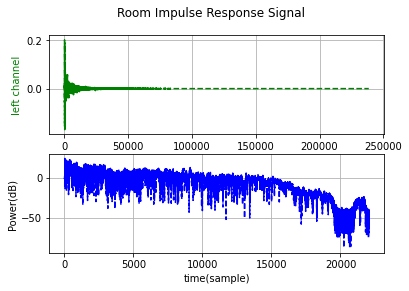

In [2]:
sr = 44100

wav = wavio.read("large_choir_hall.wav")

left_channel = wav.data[:, 0]
left_channel = left_channel.astype(np.float32, order='C') / 32767.0

x_axis = np.arange(len(left_channel))

plt.figure(1)
plt.suptitle('Room Impulse Response Signal')

plt.subplot(211)
plt.plot(x_axis, left_channel, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()


left_time = np.arange(len(left_channel))*1.0/sr
left_power = 20*np.log10(np.abs(np.fft.rfft(left_channel)))
left_frequency = np.linspace(0, sr/2.0, len(left_power))

plt.subplot(212)
plt.plot(left_frequency, left_power, 'b--')
plt.ylabel("Power(dB)")
plt.xlabel(r'time(sample)')
plt.grid()

plt.show()

In [4]:
def lms(un, dn, M, mu):
    """
    :param un: unknow signal
    :type  un: numpy.ndarray
    :param dn: expectation signal
    :type  dn: numpy.ndarray
    :param M : length of FIR filter
    :type  M : int
    :param mu: learning rate
    :type  mu: float
    :return: yn, en
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Signal buffer
    u = np.zeros(M)
    
    # FIR Weights
    w = np.zeros(M) 
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER) 
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = w + mu * en[n] * u
    return yn, en, w

def nlms(un, dn, M, mu):
    """
    :param un: unknow signal
    :type  un: numpy.ndarray
    :param dn: expectation signal
    :type  dn: numpy.ndarray
    :param M : length of FIR filter
    :type  M : int
    :param mu: learning rate
    :type  mu: float
    :return: yn, en
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Signal buffer
    u = np.zeros(M)
    
    # FIR Weights
    w = np.zeros(M) 
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER) 
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER) 
    
    for n in range(ITER):
        u[1:M] = u[0:M-1]
        u[0] = un[n]
        yn[n] = np.dot(w.T, u)
        en[n] = dn[n] - yn[n]
        w = w + mu * en[n] * u / (np.dot(u, u) + 1e-7)
    return yn, en, w

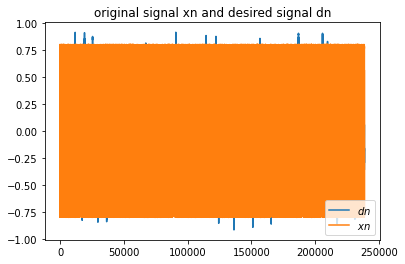

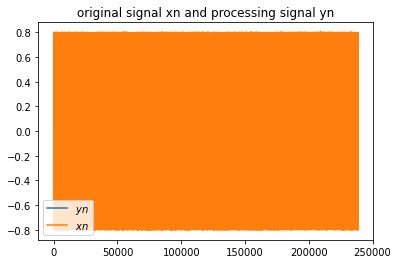

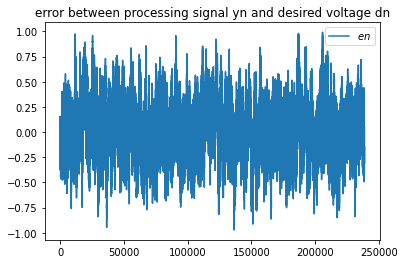

In [5]:
white = wavio.read("white_noise.wav")
white = white.data[:, 0]
white = white.astype(np.float32, order='C') / 32767.0

brown = wavio.read("brown_noise+sine.wav")
brown = brown.data[:, 0]
brown = brown.astype(np.float32, order='C') / 32767.0

# FIR taps length
M = 512
# moving steps, learning rate
mu = 0.001

xn = white
dn = brown

(yn, en, w) = lms(xn, dn, M, mu)

plt.figure(1)
plt.plot(dn,label="$dn$")
plt.plot(xn,label="$xn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(yn,label="$yn$")
plt.plot(xn,label="$xn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()

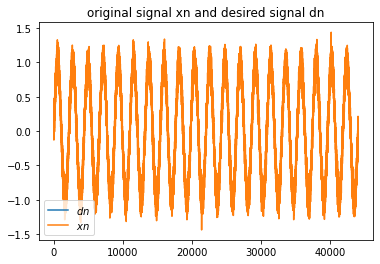

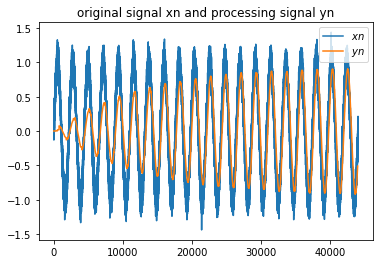

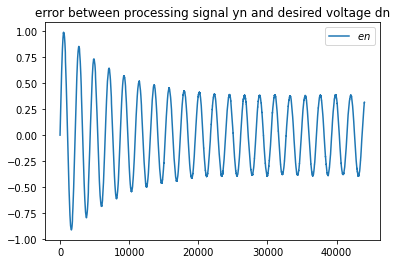

In [39]:
# iteration time
itr = 44100
# FIR taps length
M = 256
# moving steps, learning rate
mu = 0.05

beta = 0.1

noise_size = itr
X = np.linspace(0,4 * np.pi, itr, endpoint=True)
Y = np.sin(X * 10)
signal_array = Y
noise_array = np.random.normal(0, 0.1, noise_size)
signal_noise_array = signal_array + noise_array  

xn = signal_noise_array 
dn = signal_array 

(yn, en) = fdaf(xn, dn, M, mu, beta)

plt.figure(1)
plt.plot(dn,label="$dn$")
plt.plot(xn,label="$xn$")
plt.title("original signal xn and desired signal dn")
plt.legend() 

plt.figure(2)
plt.plot(xn,label="$xn$")
plt.plot(yn,label="$yn$")
plt.title("original signal xn and processing signal yn")
plt.legend()
    
plt.figure(3)
plt.plot(en,label="$en$")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()